# Catboost Model Optuna
Author: Joel Enrique Díaz Villanueva   
Organisation: Universidad de Monterrey   

---

<a name='required-standard-libraries'></a>
### Required standard libraries

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version
from pkg_resources import parse_version
import matplotlib
import matplotlib.pyplot as plt
from typing import Any
import shap

In [3]:
df = pd.read_csv('ADNI_24month_RFECV.csv')
df.drop('Paciente', axis=1, inplace=True)
print(df.shape)

(380, 13)


In [4]:
X = df.drop(["Target"], axis=1)
y = df['Target']

In [5]:
model = joblib.load('/content/catboost optuna.pkl')

In [6]:
print("Model parameters:")
print(model.get_params())

Model parameters:
{'learning_rate': 0.009641410329030103, 'depth': 10, 'l2_leaf_reg': 8.472198971974906, 'loss_function': 'Logloss', 'border_count': 194, 'random_seed': 42, 'verbose': True, 'random_strength': 1.3308204970497184, 'eval_metric': 'AUC', 'bagging_temperature': 0.406840940368113, 'subsample': 0.6347227027144912, 'scale_pos_weight': 1.322225158121818, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 19}


In [7]:
feature_names = X.columns

In [8]:
y_proba = model.predict_proba(X)[:, 1]

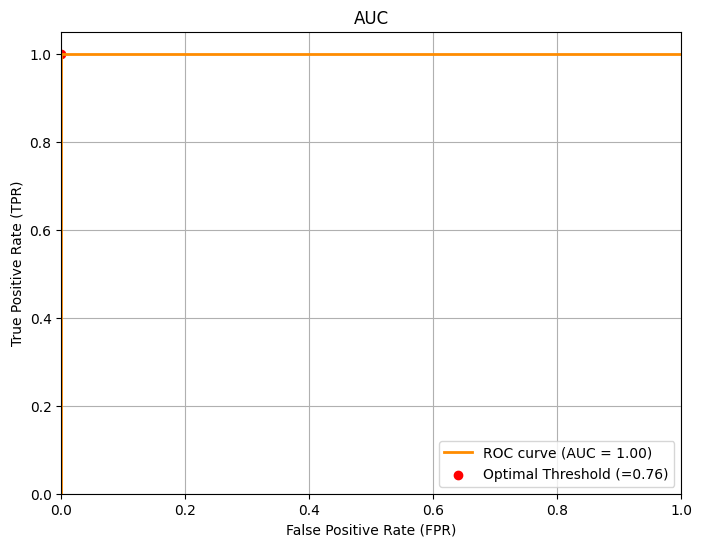

Best Threshold: 0.7553
TPR (Sensitivity): 1.0000
FPR (1-Specificity): 0.0000
AUC: 1.0000


In [9]:
fpr, tpr, thresholds = roc_curve(y, y_proba) # Calculate ROC curve

youden_index = tpr - fpr # Calculate Youden's Index to find optimal threshold
best_idx = np.argmax(youden_index)
best_threshold = thresholds[best_idx]

roc_auc = auc(fpr, tpr) # Calculate AUC

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr[best_idx], tpr[best_idx], color='red',
            label=f'Optimal Threshold (={best_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('AUC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print metrics
print(f"Best Threshold: {best_threshold:.4f}")
print(f"TPR (Sensitivity): {tpr[best_idx]:.4f}")
print(f"FPR (1-Specificity): {fpr[best_idx]:.4f}")
print(f"AUC: {roc_auc:.4f}")

In [10]:
print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
print(f"Accuracy: {model.score(X, y):.4f}")
print("\nClassification Report:\n")
print(classification_report(y, model.predict(X)))

AUC: 1.0000
Accuracy: 1.0000

Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       243
           1       1.00      1.00      1.00       137

    accuracy                           1.00       380
   macro avg       1.00      1.00      1.00       380
weighted avg       1.00      1.00      1.00       380




Confusion Matrix:


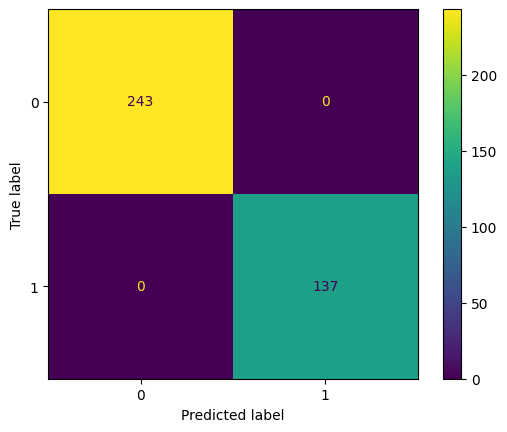

In [16]:
print("\nConfusion Matrix:")
y_predictions = (y_proba >= best_threshold).astype(int)

c_matrix = confusion_matrix(y_true=y, y_pred=y_predictions)

display_matrix = ConfusionMatrixDisplay(confusion_matrix=c_matrix)
display_matrix.plot();

In [12]:
accuracy = accuracy_score(y, y_predictions)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y, y_predictions)
print(f'Precision: {precision}')

recall = recall_score(y, y_predictions)
print(f"Recall: {recall:0.6f}")

f1 = f1_score(y, y_predictions)
print(f"F1-score: {f1:0.6f}")

Accuracy: 1.0000
Precision: 1.0
Recall: 1.000000
F1-score: 1.000000


In [13]:
def plot_permutation_importance(clf: Any, X: pd.DataFrame, y: pd.Series, ax: plt.Axes) -> plt.Axes:
    """
    Plot permutation importance results with version-safe matplotlib implementation

    Parameters:
    -----------
    clf : sklearn estimator
        Trained classifier model
    X : pd.DataFrame
        Feature matrix with column names
    y : pd.Series
        Target values
    ax : matplotlib.axes.Axes
        Axis object to plot on

    Returns:
    --------
    matplotlib.axes.Axes
        The modified axis object
    """
    # Calculate permutation importance
    result = permutation_importance(
        clf, X, y,
        n_repeats=80,
        random_state=42,
        n_jobs=2,
        scoring='accuracy'
    )

    # Sort features by importance mean
    sorted_idx = result.importances_mean.argsort()
    sorted_features = X.columns[sorted_idx]
    sorted_importances = result.importances[sorted_idx]

    # Handle matplotlib version compatibility
    label_param = "tick_labels" if parse_version(matplotlib.__version__) >= parse_version("3.9") else "labels"

    # Create boxplot
    ax.boxplot(
        sorted_importances.T,
        vert=False,
        **{label_param: sorted_features},
        patch_artist=True,
        boxprops=dict(facecolor='lightblue', alpha=0.7),
        whiskerprops=dict(color='gray'),
        capprops=dict(color='gray'),
        medianprops=dict(color='red')
    )

    # Add zero line and labels
    ax.axvline(x=0, color="k", linestyle="--", linewidth=1)
    ax.set_xlabel("Decrease in accuracy score", fontsize=12)
    ax.set_title("Permutation Importance", fontsize=14, pad=20)

    # Adjust layout
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    return ax

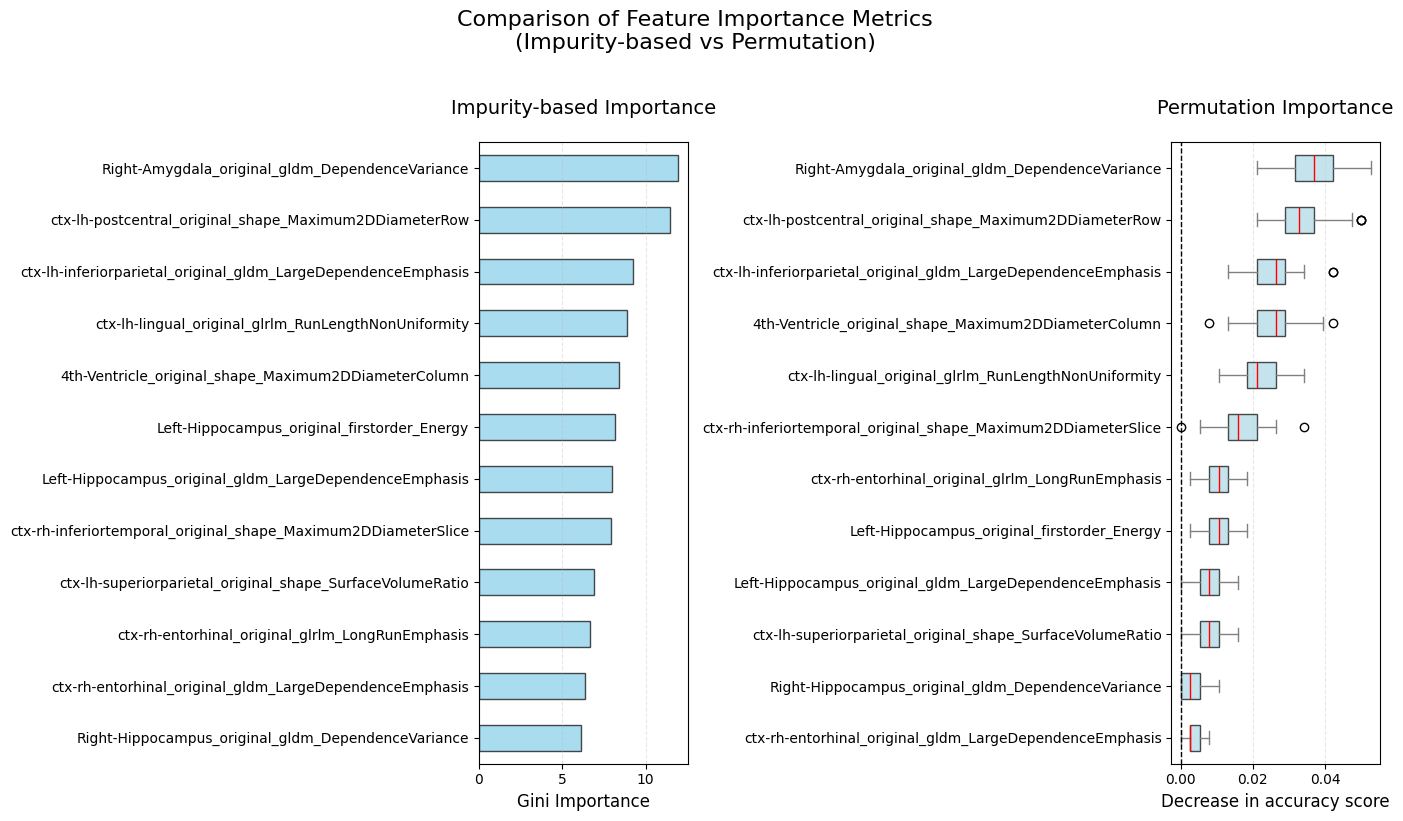

In [14]:
# Calculate Gini importances (MDI)
mdi_importances = pd.Series(
    model.feature_importances_,
    index=feature_names
).sort_values(ascending=True)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: Gini Importance (MDI)
mdi_importances.plot.barh(
    ax=ax1,
    color='skyblue',
    edgecolor='black',
    alpha=0.7
)
ax1.set_xlabel("Gini Importance", fontsize=12)
ax1.set_title("Impurity-based Importance", fontsize=14, pad=20)
ax1.grid(axis='x', linestyle='--', alpha=0.3)

# Plot 2: Permutation Importance
plot_permutation_importance(
    model,
    pd.DataFrame(X, columns=feature_names),
    y,
    ax2
)

# Overall figure settings
fig.suptitle(
    "Comparison of Feature Importance Metrics\n(Impurity-based vs Permutation)",
    fontsize=16,
    y=1.02
)
plt.tight_layout()

# Save figure if needed
plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

- Permutation Importance with Multicollinear or Correlated Features. (n.a.). Scikit-learn. https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py